In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

In [3]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

# Load surrogate model

In [4]:
Bamp_filename = '../../data/teobtest/B_amp.hdf5'
Bphase_filename = '../../data/teobtest/B_phase.hdf5'
damp_gp_filename = '../../data/teobtest/gp_amp.hdf5'
dphase_gp_filename = '../../data/teobtest/gp_phase.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

(<matplotlib.figure.Figure at 0x10a24f690>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10a254bd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10b621b90>))

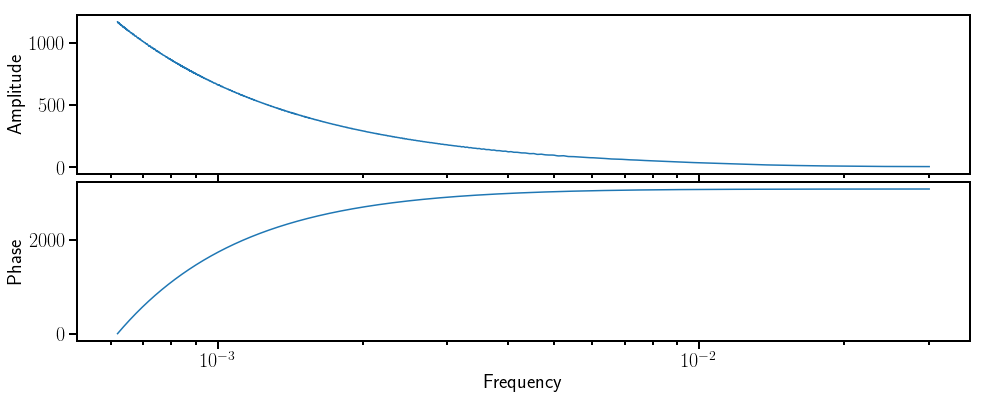

In [5]:
params = np.array([1., 0., 0., 1000., 1000.])
h = sur.geometric_waveform(params)
wave.plot_waveforms_fd([h])

In [6]:
q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0.1, 3000., 11)])
hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

(<matplotlib.figure.Figure at 0x105a2c790>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10a24e6d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10bff2d10>))

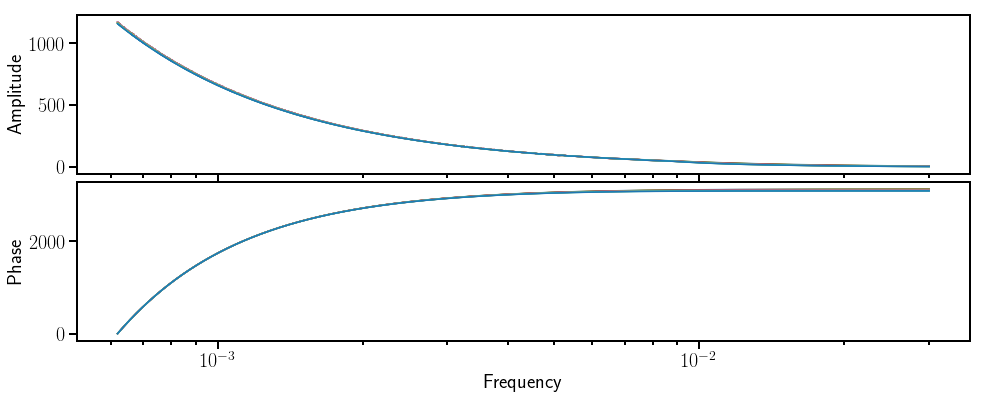

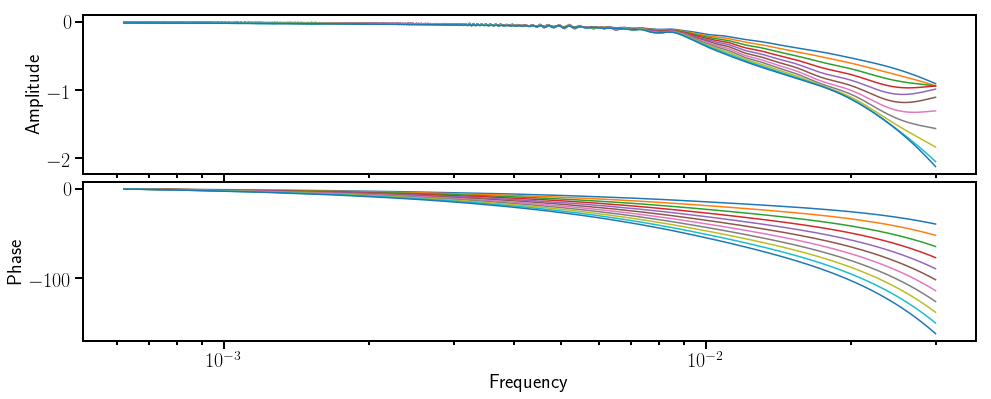

In [7]:
wave.plot_waveforms_fd(hs)
wave.plot_waveforms_fd(dhs)

In [74]:
def plot_1d_amp_phase_variation(ax_amp, ax_phase, sur, params, xi, xlow, xhigh, nx, mfs, legend=True):
    """Plot amplitude(1parameter) and phase(1parameter) as the single parameter is varied.
    Do this for all the frequencies mfs.
    
    Parameters
    ----------
    params : 1d array
        Point in full parameter space where the 1d slice should pass through
    xi : int
        Index of the parameter you want to vary
    xlow, xhigh, nx : bounds and number of samples for the feature
    mfs : 1d array
        Frequencies at which to plot the 1d variation.
    """
    xs = np.linspace(xlow, xhigh, nx)
    ps = np.array([params for j in range(len(xs))])
    for j in range(len(xs)):
        ps[j, xi] = xs[j]
    
    dhs = [sur.amp_phase_difference(p) for p in ps]
    
    amp_list = []
    phase_list = []
    for i in range(len(dhs)):
        amps = dhs[i].interpolate('amp')(mfs)
        phases = dhs[i].interpolate('phase')(mfs)
        amp_list.append(amps)
        phase_list.append(phases)
    amp_array = np.array(amp_list).T
    phase_array = np.array(phase_list).T
    
    for j in range(len(mfs)):
        ax_amp.plot(xs, amp_array[j], label=mfs[j])

    for j in range(len(mfs)):
        ax_phase.plot(xs, phase_array[j])
    
    if legend:
        ax_amp.legend(ncol=2, frameon=False)
        

def plot_all_1d_slices(sur, params, limits, labels, mfs, nx=20):
    """Plot amplitude(1parameter) and phase(1parameter) as the single parameter is varied.
    Repeat this for all parameters.
    
    Parameters
    ----------
    params : 1d array
        Point in full parameter space where the 1d slice should pass through
    xi : int
        Index of the parameter you want to vary
    xlow, xhigh, nx : bounds and number of samples for the feature
    mfs : 1d array
        Frequencies at which to plot the 1d variation.
    """
    nparams = len(limits)
    fig, ax = plt.subplots(2, nparams, figsize=(min(8*nparams, 20), 6))
    title = '{:.3}, {:.2}, {:.2}, {:.1f}, {:.1f}'.format(params[0], params[1], params[2], params[3], params[4])
    fig.suptitle(title)
    for xi in range(nparams):
        ax1 = ax[0, xi]
        ax2 = ax[1, xi]
        xlow = limits[xi, 0]
        xhigh = limits[xi, 1]
        if xi==0:
            legend = True
            ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
            ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
        else:
            legend = False
        plot_1d_amp_phase_variation(ax1, ax2, sur, params, xi, xlow, xhigh, nx, mfs, legend=legend)
        ax1.minorticks_on()
        ax2.minorticks_on()
        ax1.xaxis.set_ticklabels([])
        ax2.set_xlabel(labels[xi])
        # Manually rotate every single label 
        for label in ax2.get_xticklabels():
            label.set_rotation(45) 
    fig.subplots_adjust(hspace=0.0, wspace=0.25)

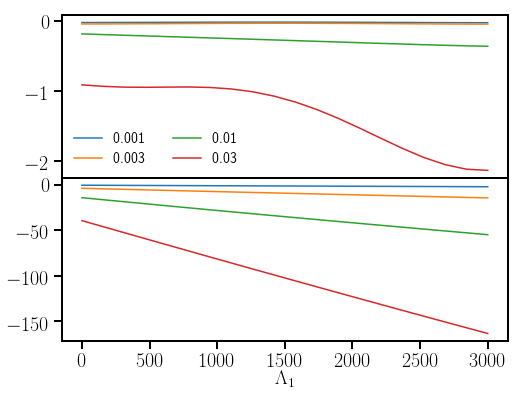

In [70]:
params = np.array([1.0, 0.3, 0.1, 1000., 1000.])
xi = 3
xlow = 0.1
xhigh = 3000.
nx = 20
mfs = np.array([0.001, 0.003, 0.01, 0.03])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plot_1d_amp_phase_variation(ax1, ax2, sur, params, xi, xlow, xhigh, nx, mfs)
ax2.set_xlabel(r'$\Lambda_1$')

fig.subplots_adjust(hspace=0.0, wspace=0.0)

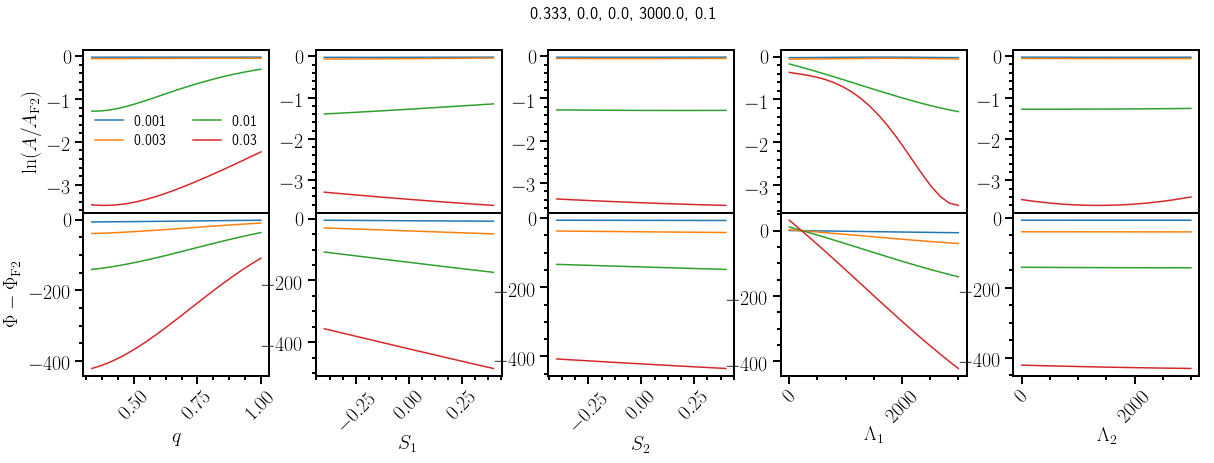

In [75]:
params = np.array([1.0/3.0, 0.0, 0.0, 3000, 0.1])
limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
mfs = np.array([0.001, 0.003, 0.01, 0.03])

plot_all_1d_slices(sur, params, limits, labels, mfs)

# Add new points with uncertainty sampling

In [20]:
original_points = sur.dphase_gp_list[0].X_train_
#limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
kernel_type = 'matern52'
dphase_gp_list = sur.dphase_gp_list

sampler = us.UncertaintySampling(original_points, limits, kernel_type, dphase_gp_list)

In [35]:
sampler.add_new_points(5, nbasinjumps=100, nfun_eval_per_basin=30, verbose=True)

0 err_new=8.09004381325, neval=8850, evaluation time=40.066521883
point_new=[  7.891467e-01   4.000000e-01  -4.000000e-01   1.523582e+03   3.000000e+03]
1 err_new=6.88485230988, neval=8652, evaluation time=39.3307650089
point_new=[  7.609539e-01   4.000000e-01   4.000000e-01   3.000000e+03   3.000000e+03]
2 err_new=6.83933590336, neval=8436, evaluation time=38.1213779449
point_new=[  7.952997e-01  -4.000000e-01   2.510819e-01   1.459617e+03   1.000299e-01]
3 err_new=6.71964509601, neval=8646, evaluation time=39.5637872219
point_new=[  6.780518e-01   4.000000e-01   4.000000e-01   1.000000e-01   3.000000e+03]
4 err_new=5.81209398711, neval=8154, evaluation time=38.4881432056
point_new=[  4.902811e-01  -4.000000e-01   3.974098e-01   3.000000e+03   1.672912e+02]


In [36]:
points_errors = np.concatenate((sampler.new_points.T, np.array([sampler.new_errors]))).T
print len(points_errors)

#np.savetxt('../../data/uncertainty_sampling_from_lhd_trainset.txt', points_errors)

15


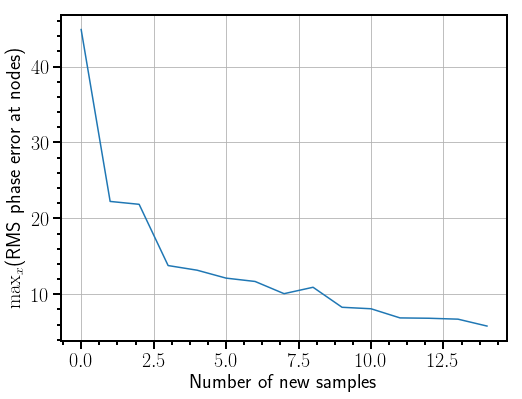

In [37]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(sampler.new_errors)
#axes.scatter(360, 0.343, label='')
axes.set_xlabel('Number of new samples')
axes.set_ylabel(r'$\max_x$(RMS phase error at nodes)')
axes.minorticks_on()
#axes.set_ylim(0, 2.5)
axes.grid()

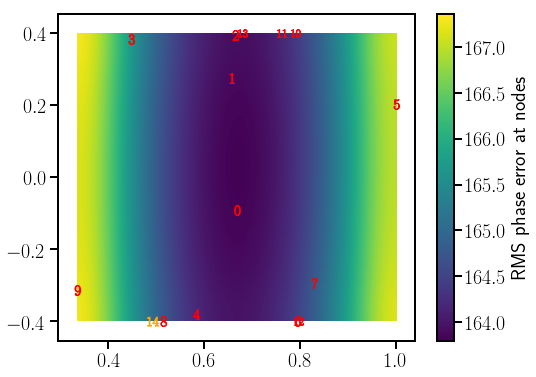

In [38]:
x0, x1, x2, x3, x4 = 1.0, 0.7, -0.7, 10000., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return -sampler.negative_error(point)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, 
             colorbar_label=r'RMS phase error at nodes')
plot_numbered_points(ax1, sampler.new_points)

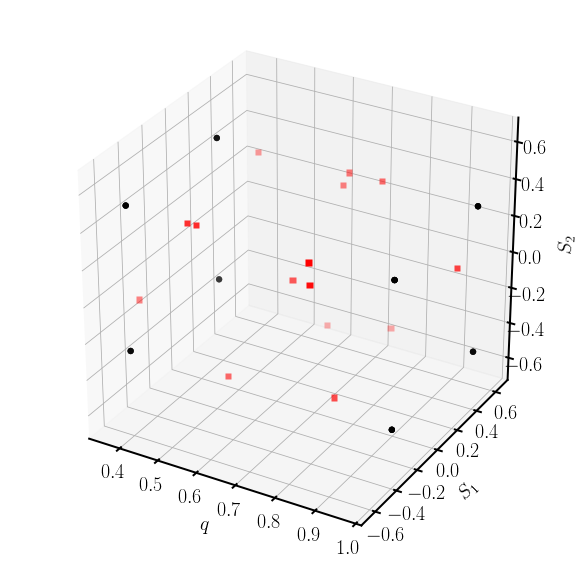

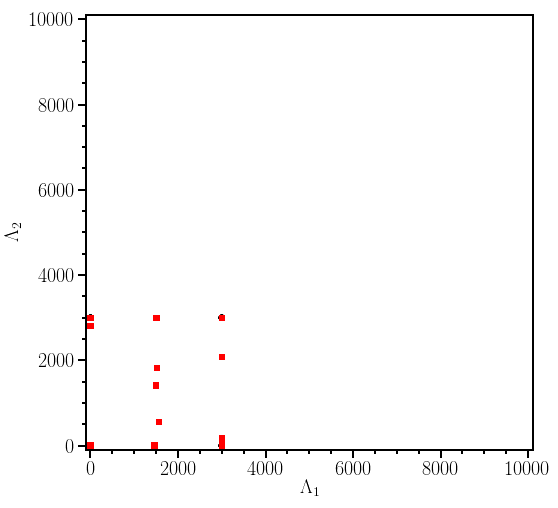

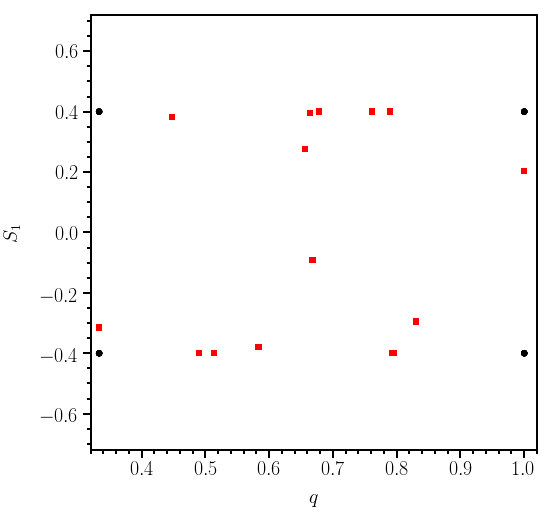

In [39]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111, projection='3d')

x, y, z = original_points[:, 0], original_points[:, 1], original_points[:, 2]
axes.scatter(x, y, z, c='k', edgecolor='none', marker='o', s=40)

x, y, z = sampler.new_points[:, 0], sampler.new_points[:, 1], sampler.new_points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.333, 1.0)
axes.set_ylim(-0.7, 0.7)
axes.set_zlim(-0.7, 0.7)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.set_zlabel('$S_2$', labelpad=18)
#axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 3], original_points[:, 4]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 3], sampler.new_points[:, 4]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(-100, 10100)
axes.set_ylim(-100, 10100)
axes.set_xlabel('$\Lambda_1$')
axes.set_ylabel('$\Lambda_2$')
axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 0], original_points[:, 1]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 0], sampler.new_points[:, 1]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.32, 1.02)
axes.set_ylim(-0.72, 0.72)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.minorticks_on()

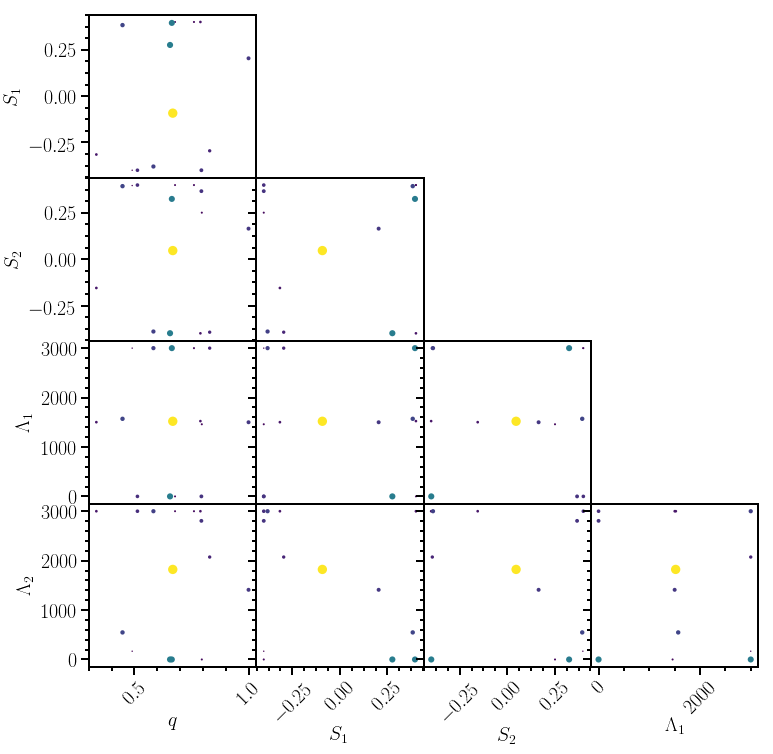

In [40]:
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
params = sampler.new_points
error = sampler.new_errors
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

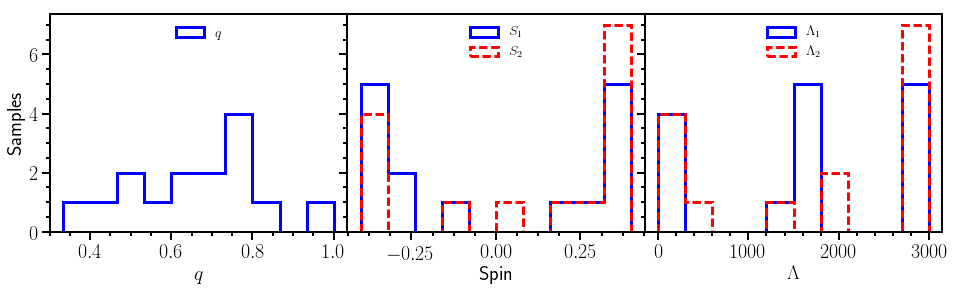

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
fig.subplots_adjust(wspace=0.0)


# Mass ratio
ax1.hist(sampler.new_points[:, 0], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$q$')
ax1.set_xlabel(labels[0])
ax1.set_ylabel('Samples')
ax1.legend(loc='upper center', frameon=False)
ax1.minorticks_on()


# Spins
ax2.hist(sampler.new_points[:, 1], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$S_1$')

ax2.hist(sampler.new_points[:, 2], bins=10, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$S_2$')

ax2.set_xlabel('Spin')
ax2.legend(loc='upper center', frameon=False)
ax2.minorticks_on()


# Tidal parameters
ax3.hist(sampler.new_points[:, 3], bins=10, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\Lambda_1$')

ax3.hist(sampler.new_points[:, 4], bins=10, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$\Lambda_2$')

ax3.set_xlabel(r'$\Lambda$')
ax3.legend(loc='upper center', frameon=False)
ax3.minorticks_on()